In [7]:
import sys
sys.path.append('../../../vysxd')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from vysxd_define import *
from vysxd_analysis import *

%matplotlib inline

In [142]:
# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3/MS/DENSITY/electrons/charge/')
# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3_vth-0.1/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3_vth-0.1/MS/DENSITY/electrons/charge/')

# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3_vth-0.1_sin2driver/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.3_vth-0.1_sin2driver/MS/DENSITY/electrons/charge/')

# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.33_vth-0.11_sin2driver/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.33_vth-0.11_sin2driver/MS/DENSITY/electrons/charge/')

# e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.33_vth-0.05_sin2driver/MS/FLD/e1/')
# edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('./klD-0.33_vth-0.05_sin2driver/MS/DENSITY/electrons/charge/')

e1_D_xt, dt, dx, t, x = get_osiris_quantity_1d('EPW-alves/MS/FLD/e1/')
edens_D_xt, dt, dx, t, x = get_osiris_quantity_1d('EPW-alves/MS/DENSITY/electrons/charge/')
p1x1 = vysxd_get_data('EPW-alves/MS/PHA/p1x1/electrons/p1x1-electrons-000100.h5')

In [145]:
np.shape(p1x1.DATA)
print(len(p1x1.Y))
print(len(p1x1.X))
phasearray = p1x1.DATA
phasearray[127,95]

v_p = p1x1.Y
x_p = p1x1.X

#n_v = np.linspace(0, len(v_p)-1,len(v_p))
#n_v = n_v.astype(int)
#n_v = n_v.tolist()
#print(n_v)

#def p1x1(t):
#    p1x1_files = np.sort(os.listdir('EPW-alves/MS/PHA/p1x1/electrons/'))
#    if not (os.path.isdir('figures-xv-density')):
#        os.makedirs('figures-xv-density')
#    for i in range(len(p1x1_files)):
#        p1x1 = vysxd_get_data('EPW-alves/MS/PHA/p1x1/electrons/' + p1x1_files[i])

def position_averaged_f_v(array):
    n_v = np.linspace(0, len(v_p)-1,len(v_p))
    n_v = n_v.astype(int)
    n_v = n_v.tolist()
    n_x = np.linspace(0, len(x_p)-1,len(x_p))
    n_x = n_x.astype(int)
    n_x = n_x.tolist()
    PAV = []
    for i in n_v:
        integral = np.trapz(array[i,n_x], x_p)
        PAV.append(integral)
    return PAV

v_input = v_p.tolist()
v_ave = v_input[3:-3]

def coarse_grained_in_v(array):
    v_input = v_p.tolist()
    v_ave = v_input[3:-3]
    CGF = np.zeros([128,96])
    CGF += array
    for i in range(0,len(v_ave)):
        for j in range(0,len(x_p)):
            coarse_grain = (1/7)*(0.3*array[i,j]+array[i+1,j]+1.4*array[i+2,j]+1.6*array[i+3,j]+1.4*array[i+4,j]+array[i+5,j]+0.3*array[i+6,j])
            CGF[i+3,j] = coarse_grain
    return CGF

def coarse_grained_in_x(array):
    x_input = x_p.tolist()
    x_ave = x_input[3:-3]
    CGF = np.zeros([128,96])
    CGF += array
    for i in range(0,len(x_ave)):
        for j in range(0,len(v_p)):
            coarse_grain = (1/7)*(0.3*array[j,i]+array[j,i+1]+1.4*array[j,i+2]+1.6*array[j,i+3]+1.4*array[j,i+4]+array[j,i+5]+0.3*array[j,i+6])
            CGF[j,i+3] = coarse_grain
    return CGF

def gradv(array):
    GVA = np.zeros([128,96])
    for i in range(0,len(x_p)):
        gradv = np.gradient(array[:,i])
        GVA[:,i] = gradv
    return GVA

def gradx(array):
    GXA = np.zeros([128,96])
    for i in range(0,len(v_p)):
        gradx = np.gradient(array[i,:])
        GXA[i,:] = gradx
    return GXA

def dWdt(v_p,x_p,t_index,gradv,gradx,e1,q_m=-1):
    n_v = np.linspace(0, len(v_p)-1,len(v_p))
    n_v = n_v.astype(int)
    n_v = n_v.tolist()
    n_x = np.linspace(0, len(x_p)-1,len(x_p))
    n_x = n_x.astype(int)
    n_x = n_x.tolist()
    PAV = []
    for i in n_v:
        vsquared = (v_p[i])**2
        vcubed = (v_p[i])**3
        integral = -np.trapz((q_m*vsquared*e1[t_index,n_x]*gradv[i,n_x])+(vcubed*gradx[i,n_x]), x_p)
        PAV.append(integral)
    return PAV
#q/m = rqm in input file which should be -1 for electrons
#input v_p for v_p, x_p for x_p, the time index for T and e1_D_xt for el.


128
96


(100, 96)

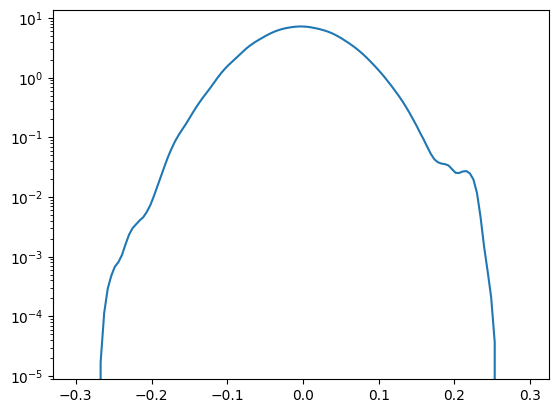

In [151]:
P = coarse_grained_in_v(phasearray)
Q = coarse_grained_in_x(P)
gradP = gradv(P)
#v_input = v_p.tolist()
#v_ave = v_input[3:-3]
#print(P)
#plt.plot(v_p,position_averaged_f_v(phasearray))
#plt.plot(v_p,phasearray[:,80])
#plt.plot(v_p,np.gradient(phasearray[:,80]))
#phasearray[70,:]
#plt.plot(v_p,phasearray[:,80])
#plt.plot(v_p,np.gradient(phasearray[:,80]))
#plt.plot(v_p,P[:,80])
#plt.plot(v_p,gradP[:,80])

plt.semilogy(v_p,abs(P[:,80]))

len(np.gradient(P[:,80]))
np.shape(e1_D_xt)


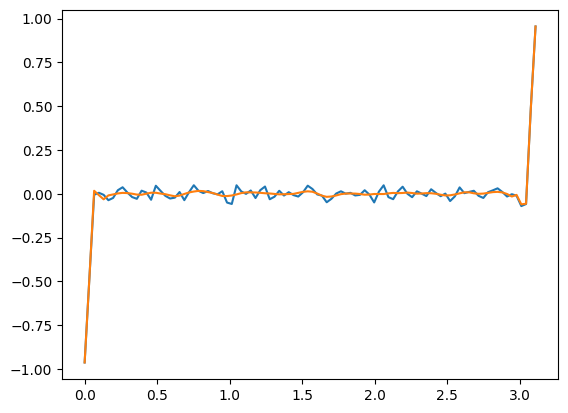

In [139]:

P = coarse_grained_in_v(phasearray)
Q = coarse_grained_in_x(P)

Billy = gradx(P)
#plt.plot(x_p,P[64,:])
plt.plot(x_p,Billy[64,:])

Mandy = gradx(Q)
#plt.plot(x_p,Q[64,:])
plt.plot(x_p,Mandy[64,:])

[-4.455001113893426e-09, -2.1584350576510897e-09, -4.673328122973655e-10, 3.06824223831435e-11, 1.5124303473262359e-09, 1.1177139472004935e-08, 6.066613978424383e-08, 1.4641155770869688e-07, 2.063095429452916e-07, 2.3169777281799444e-07, 2.0868680528809192e-07, 1.0615253234591742e-07, -1.4768443023982807e-08, -6.224980344699337e-08, 5.583164206298968e-10, 1.2037999740306175e-07, 2.704809339638214e-07, 3.965134019613801e-07, 5.18424928979789e-07, 7.733898127594322e-07, 1.0754179769545476e-06, 1.2584138526793263e-06, 1.2382395112122823e-06, 9.071855794388791e-07, 4.907924770388025e-07, 1.439380994618761e-07, -7.426913763201028e-08, -1.1666257334950332e-07, 3.2084745963788724e-07, 8.626425490992454e-07, 1.1001523612085981e-06, 1.2671119122399887e-06, 1.3935779443831843e-06, 1.3556280030879947e-06, 9.38307913461551e-07, 3.216642597029915e-07, -8.225587289081262e-07, -1.762888287211464e-06, -2.2902684443165906e-06, -2.3622393495199896e-06, -2.0507317113627216e-06, -1.6920355260459104e-06, -

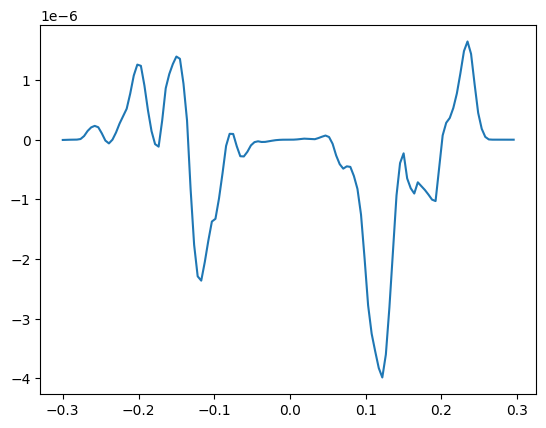

In [155]:
P = coarse_grained_in_v(phasearray)
Q = coarse_grained_in_x(P)

#print(t)
#print(p1x1.TIME)

KE_change = dWdt(v_p,x_p,99,gradv(Q),gradx(Q),e1_D_xt)

print(KE_change)
print(len(KE_change))
print(len(v_p))
plt.plot(v_p,KE_change)
